In [1]:
import numpy as np
import qutip as qt
import cvxpy as cp
from scipy.linalg import logm, expm
from scipy.optimize import nnls
import matplotlib.pyplot as plt

In [2]:
def generate_hamiltonians(a_values, b_values):
    sigma_z = qt.sigmaz()
    sigma_x = qt.sigmax()
    hamiltonians = {}
    for a in a_values:
        for b in b_values:
            H = 0.5 * a * sigma_z + 0.5 * b * sigma_x
            hamiltonians[(a, b)] = H
    return hamiltonians


In [3]:
def time_evolve_state(H, psi0, tlist):
    result = qt.sesolve(H, psi0, tlist)
    return result.states

In [4]:
def _phi_of_rho_from_choi(J, rho):
    I2 = np.eye(2)
    rho_T = rho.T
    temp = cp.matmul(cp.kron(I2, rho_T), J)  # (I ⊗ ρ^T) J  (4x4)
    # Partial trace over input (X): block-sum of 2x2 diagonal blocks
    Phi_rho = temp[0:2, 0:2] + temp[2:4, 2:4]
    return Phi_rho

In [5]:
def _trace_over_Y_equals_I(J):
    TrY = J[0:2, 0:2] + J[2:4, 2:4]
    return TrY == np.eye(2)

In [6]:
def _covariance_constraints(J, H):
    I2 = np.eye(2)
    G_left  = np.kron(H, I2)    # H ⊗ I
    G_right = np.kron(I2, H.T)  # I ⊗ H^T
    return [ G_left @ J - J @ G_right == 0 ]

In [7]:
def fidelity_sdp_step(rho_qobj, sigma_qobj, H_qobj,
                      impose_covariance=True,
                      impose_passivity=False):
    rho = rho_qobj.full()
    sigma = sigma_qobj.full()
    H = H_qobj.full()

    J = cp.Variable((4, 4), complex=True)  # Choi(Φ)
    W = cp.Variable((2, 2), complex=True)  # fidelity witness

    constraints = [J >> 0, _trace_over_Y_equals_I(J)]
    if impose_covariance:
        constraints += _covariance_constraints(J, H)

    Phi_rho = _phi_of_rho_from_choi(J, rho)

    if impose_passivity:
        lhs = cp.real(cp.trace(H @ Phi_rho))
        rhs = float(np.trace(H @ rho))
        constraints += [ lhs <= rhs + 1e-12 ]

    block = cp.bmat([[Phi_rho, W], [W.H, sigma]])
    constraints.append(block >> 0)

    objective = cp.Maximize(cp.real(cp.trace(W)))
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS, verbose=False)

    return {
        "status": prob.status,
        "fidelity": prob.value,
        "J": None if J.value is None else J.value.copy(),
        "W": None if W.value is None else W.value.copy(),
        "Phi_rho": None if Phi_rho.value is None else Phi_rho.value.copy(),
    }

In [8]:
def kraus_from_choi(J_opt):
    J_q = qt.Qobj(J_opt, dims=[[2, 2], [2, 2]])
    evals, evecs = J_q.eigenstates()
    kraus_ops = []
    for lam, vec in zip(evals, evecs):
        if np.real(lam) > 1e-10:
            K = np.sqrt(lam) * vec.full().reshape(2, 2, order='F')
            kraus_ops.append(qt.Qobj(K))
    return kraus_ops

In [9]:
def super_from_kraus(kops):
    Phi = np.zeros((4, 4), dtype=complex)
    for K in kops:
        Kmat = K.full()
        Phi += np.kron(Kmat, Kmat.conj())
    return Phi

In [10]:
def phase_covariant_basis():
    """Basis for L = ω*Bh + γ↓*Bd + γ↑*Bu + γφ*Bp."""
    sz = qt.sigmaz(); sp = qt.sigmap(); sm = qt.sigmam()
    H_unit = 0.5 * sz
    Lh = qt.liouvillian(H_unit, []).full()
    Ld = qt.liouvillian(0*sz, [sm]).full()
    Lu = qt.liouvillian(0*sz, [sp]).full()
    Lp = qt.liouvillian(0*sz, [sz]).full()
    return Lh, Ld, Lu, Lp

In [11]:
def nearest_phase_covariant_GKSL_from_channel(kraus_ops, eps=1e-7):
    """Fit a phase-covariant GKSL generator to a qubit channel (from Kraus ops)."""
    # 1) Build channel superoperator
    Phi = np.zeros((4,4), dtype=complex)
    for K in kraus_ops:
        K = K.full() if isinstance(K, qt.Qobj) else K
        Phi += np.kron(K, K.conj())

    # 2) Regularized log
    Phi_reg = (1 - eps) * Phi + eps * np.eye(4)
    L_raw = logm(Phi_reg)

    # 3) Project to trace-preserving subspace: <vec(I)| L = 0
    vI = np.eye(2).reshape(-1,1,order='F')
    row = vI.conj().T @ L_raw
    denom = float(vI.conj().T @ vI)  # = 2
    L_raw_tp = L_raw - vI @ (row / denom)

    # 4) Fit real parts to phase-covariant GKSL basis via NNLS
    Bh, Bd, Bu, Bp = phase_covariant_basis()
    A = np.column_stack([Bh.reshape(-1,1), Bd.reshape(-1,1), Bu.reshape(-1,1), Bp.reshape(-1,1)]).real
    b = np.real(L_raw_tp.reshape(-1,1))

    # ω free (±), rates ≥ 0: split ω into ωp-ωm
    A_omega = np.column_stack([A[:,0:1], -A[:,0:1]])
    A_nnls = np.hstack([A_omega, A[:,1:]])
    x, _ = nnls(A_nnls, b.ravel())
    omega = x[0] - x[1]
    g_down, g_up, g_phi = x[2:]

    L_gksl = omega*Bh + g_down*Bd + g_up*Bu + g_phi*Bp
    Lq = qt.Qobj(L_gksl, dims=[[2,2],[2,2]])
    params = dict(omega=omega, gamma_down=g_down, gamma_up=g_up, gamma_phi=g_phi)
    return Lq, params

In [12]:
def verify_L(L_qobj, t=0.1):
    """Quick checks: TP, Hermiticity, CP of e^{tL}."""
    Lm = L_qobj.full()
    I2 = np.eye(2)
    vI = I2.reshape(-1,1,order='F')
    tp_err = np.linalg.norm(vI.conj().T @ Lm)

    rho = qt.rand_dm(2).full()
    rho = 0.5*(rho + rho.conj().T)
    out = (Lm @ rho.reshape(-1,1,order='F')).reshape(2,2,order='F')
    herm_err = np.linalg.norm(out - out.conj().T)

    Phi_t = expm(Lm * t)
    J = Phi_t @ vI @ vI.conj().T
    eigs = np.linalg.eigvalsh(J)
    return tp_err, herm_err, eigs

In [13]:
def gksl_liouvillian(params):
    ω = params['omega']
    γd = params['gamma_down']
    γu = params['gamma_up']
    γφ = params['gamma_phi']
    H_eff = 0.5 * ω * qt.sigmaz()
    c_ops = []
    if γd > 1e-12:
        c_ops.append(np.sqrt(γd) * qt.sigmam())
    if γu > 1e-12:
        c_ops.append(np.sqrt(γu) * qt.sigmap())
    if γφ > 1e-12:
        c_ops.append(np.sqrt(γφ) * qt.sigmaz())
    return qt.liouvillian(H_eff, c_ops)

In [51]:
def evolve_gksl_piecewise(gksl_params_list, tlist, rho0, exact_step=True):
    """Piecewise-constant GKSL evolution over tlist using params per step."""
    rho = rho0
    rho_list = [rho0]
    dt = tlist[1] - tlist[0]

    for params in gksl_params_list:
        L = gksl_liouvillian(params)

        # Vectorize the current density matrix
        rho_vec = qt.operator_to_vector(rho).full()  # shape (4, 1)

        # Propagate
        if exact_step:
            Phi = expm(L.full() * dt)
            rho_vec_next = Phi @ rho_vec
        else:
            rho_vec_next = (np.eye(4) + L.full() * dt) @ rho_vec

        # ---- Manual reshape back to 2x2 operator ----
        rho_next = qt.Qobj(rho_vec_next.reshape((2, 2), order='F'))

        # Normalize to correct small numerical drift
        rho_next = rho_next / rho_next.tr()

        rho = rho_next
        rho_list.append(rho)

    return rho_list


In [39]:
a_vals = np.linspace(-2, 2, 5)
b_vals = np.linspace(-1, 1, 5)
hams = generate_hamiltonians(a_vals, b_vals)

In [40]:
key = (-2.0, -1.0)
H = hams[key]
tlist = np.linspace(0, 5, 100)

In [41]:
evals, evecs = H.eigenstates(sort='low')
ground = evecs[0]
excited = evecs[1]
rho0 = qt.ket2dm(ground)
sigma_target = qt.ket2dm(excited)

In [42]:
states_t = time_evolve_state(H, ground, tlist)

In [43]:
impose_covariance = True
impose_passivity = False

sdp_fidelities = []
sdp_kraus_list = []
for psi_t in states_t:
    rho_t = qt.ket2dm(psi_t)
    out = fidelity_sdp_step(rho_t, sigma_target, H,
                            impose_covariance=impose_covariance,
                            impose_passivity=impose_passivity)
    sdp_fidelities.append(out["fidelity"])
    # Kraus list may be empty if solver failed → guard
    kops = kraus_from_choi(out["J"]) if out["J"] is not None else []
    sdp_kraus_list.append(kops)

print(f"Solved {len(tlist)} SDPs. Fidelity range:",
      float(np.nanmin(sdp_fidelities)), float(np.nanmax(sdp_fidelities)))

Solved 100 SDPs. Fidelity range: 2.4340819147761206e-05 8.998885792091578e-05


In [44]:
gksl_results = []
for kops in sdp_kraus_list:
    if len(kops) == 0:
        # Fallback: zero generator (identity channel)
        Lq = qt.Qobj(np.zeros((4,4)), dims=[[2,2],[2,2]])
        params = dict(omega=0.0, gamma_down=0.0, gamma_up=0.0, gamma_phi=0.0)
    else:
        Lq, params = nearest_phase_covariant_GKSL_from_channel(kops, eps=1e-7)
    gksl_results.append((Lq, params))

/var/folders/7d/xvfh5ghn7gd9q1vmfcky51h80000gn/T/ipykernel_15338/3733396937.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  denom = float(vI.conj().T @ vI)  # = 2


In [45]:
# Quick sanity on the first fitted generator
L_gksl, params0 = gksl_results[0]
print("First-step fitted GKSL params:", params0)
tp_err, herm_err, eigs = verify_L(L_gksl, t=0.1)
print("First-step TP error:", tp_err)
print("First-step Herm error:", herm_err)
print("First-step Choi eigs:", np.round(eigs, 12))

First-step fitted GKSL params: {'omega': np.float64(0.0), 'gamma_down': np.float64(0.33863450863290795), 'gamma_up': np.float64(0.31535854858761775), 'gamma_phi': np.float64(1.1266878391208672)}
First-step TP error: 0.0
First-step Herm error: 0.0
First-step Choi eigs: [-0.00225565  0.          0.          2.00225565]


In [46]:
gksl_params_list = [p for (_, p) in gksl_results]


In [ ]:
# ==============================
#  Evolve under piecewise GKSL and compute fidelities
# ==============================
tlist = np.linspace(0, 30, 100)
rho0 = 
rho_list = evolve_gksl_piecewise(gksl_params_list, tlist, rho0, exact_step=True)
fids_gksl = [qt.fidelity(rho, excited) for rho in rho_list]

# Unitary overlap (reference)
unitary_overlaps = [abs(excited.overlap(psi_t)) for psi_t in states_t]


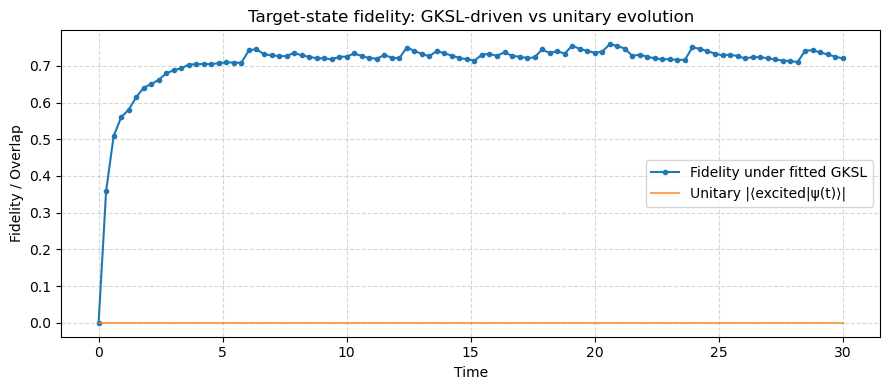

In [57]:
plt.figure(figsize=(9,4))
plt.plot(tlist, fids_gksl[:-1], label="Fidelity under fitted GKSL", marker='o', ms=3)
plt.plot(tlist, unitary_overlaps, label="Unitary |⟨excited|ψ(t)⟩|", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Fidelity / Overlap")
plt.title("Target-state fidelity: GKSL-driven vs unitary evolution")
plt.grid(True, ls="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [58]:
# From your fitted params per step:
g_up = np.array([p['gamma_up'] for p in gksl_params_list])
g_dn = np.array([p['gamma_down'] for p in gksl_params_list])

# Predict steady-state overlap and fidelity
p_ss = g_up / (g_up + g_dn + 1e-16)   # avoid divide-by-zero
F_ss_pred = np.sqrt(np.clip(p_ss, 0, 1))

print("Predicted asymptotic fidelity (median over time):", np.median(F_ss_pred))
print("Observed plateau (median of last ~20% points):", np.median(fids_gksl[int(0.8*len(fids_gksl)):-1]))

Predicted asymptotic fidelity (median over time): 0.7037979381317394
Observed plateau (median of last ~20% points): 0.7260144424488397


Observed late-time median fidelity: 0.7260144424488397
Median of instantaneous steady-state fidelities: 0.7037979381317394
Steady-state fidelity if we freeze final rates: 0.7052616240545173


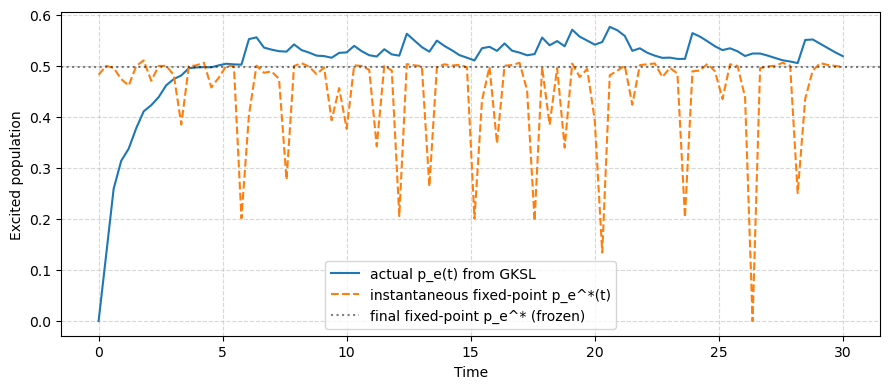

In [60]:
# Actual excited-state population from your GKSL trajectory
p_e_actual = np.array([np.real(excited.dag() * rho * excited) for rho in rho_list]).flatten()

# Instantaneous stationary populations from fitted rates
g_up  = np.array([p['gamma_up']   for p in gksl_params_list])
g_dn  = np.array([p['gamma_down'] for p in gksl_params_list])
p_ss_inst = g_up / (g_up + g_dn + 1e-16)  # avoid divide-by-zero
F_inst = np.sqrt(np.clip(p_ss_inst, 0, 1))

# "Freeze the last generator" stationary point:
p_ss_final = p_ss_inst[-1]
F_ss_final = np.sqrt(p_ss_final)

print("Observed late-time median fidelity:", np.median([qt.fidelity(rho, excited) for rho in rho_list[int(0.8*len(rho_list)):-1]]))
print("Median of instantaneous steady-state fidelities:", np.median(F_inst))
print("Steady-state fidelity if we freeze final rates:", F_ss_final)

# Optional: plot populations and predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(9,4))
plt.plot(tlist, p_e_actual[:-1], label="actual p_e(t) from GKSL")
plt.plot(tlist, p_ss_inst, '--', label="instantaneous fixed-point p_e^*(t)")
plt.axhline(p_ss_final, color='k', alpha=0.5, linestyle=':', label="final fixed-point p_e^* (frozen)")
plt.xlabel("Time"); plt.ylabel("Excited population")
plt.legend(); plt.grid(True, ls='--', alpha=0.5); plt.tight_layout(); plt.show()